In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import os
import pandas as pd
import torch.nn.functional as F

from lib.utils import get_free_gpu, load_lizard, debug
from lib.utils_vis import make_seed, to_rgb
from lib.EnergyCAModel import EnergyCAModel
from lib.CAModel import CAModel
from lib.utils import animate_steps
model_dir = 'models/'

# Initialization


Getting free GPU...
| ID | GPU | MEM |
------------------
|  0 | 20% | 48% |
|  1 |  0% |  0% |
|  2 | 84% | 91% |
|  3 |  0% | 91% |
|  4 | 20% | 91% |
Using GPU:  1


/nfs_home/charneca/miniconda3/envs/nca/lib/python3.9/site-packages/torch/cuda/__init__.py:132: UserWarning: 
    Found GPU4 Tesla K40c which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))


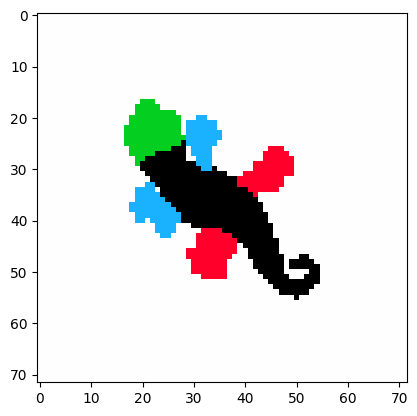

In [2]:

torch.backends.cudnn.benchmark = True # Speeds up stuff
torch.backends.cudnn.enabled = True

## General Parameters ##
global_params = {
    'CHANNEL_N': 16,
    'TARGET_PADDING': 16,
    'TARGET_SIZE': 40,
    'IMG_SIZE': 72,
    'MIN_STEPS': 64,
    'MAX_STEPS': 128,
}

## General Training Parameters ##
# choose cuda device with the least amount of current memory usage
training_params = {
    'lr': 2e-3,
    'lr_gamma': 0.9999,
    'betas': (0.5, 0.5),
    'n_epoch': 10000,
    'batch_size': 1,#8,
    'grad_clip': 1.0,
    'device': torch.device('cuda:{}'.format(get_free_gpu()) if torch.cuda.is_available() else 'cpu'),
    'history_save_dir': 'histories/',
    'model_save_dir': 'models/gumbel/', ###
}

ca_params = {"CELL_FIRE_RATE": 0.5}
number_of_batches = 10#10

# Load target emoji
target_img = load_lizard('data/lizard_clean.png')
p = global_params['TARGET_PADDING']
pad_target = np.pad(target_img, [(p, p), (p, p), (0, 0)])
h, w = pad_target.shape[:2]
pad_target = np.expand_dims(pad_target, axis=0)
pad_target = torch.from_numpy(pad_target.astype(np.float32))

# Load body parts emoji
parts_img = load_lizard('data/lizard_parts.png')
pad_parts = np.pad(parts_img, [(p, p), (p, p), (0, 0)])

# Create initial state
seed = make_seed((h, w), global_params['CHANNEL_N'])
x0 = np.repeat(seed[None, ...], training_params["batch_size"], 0)
x0 = torch.from_numpy(x0.astype(np.float32)).to(training_params['device'])

plt.imshow(to_rgb(pad_target.detach().cpu()[0]))
plt.imshow(pad_parts)

In [3]:
# create body parts mask
parts_mask = {"head": np.zeros((h, w)), "body": np.zeros((h, w)), "front_legs": np.zeros((h, w)), "back_legs": np.zeros((h, w))}
parts_mask["head"] = pad_parts[:,:,1] > 0.8
parts_mask["front_legs"] = pad_parts[:,:,2] > 0.8
parts_mask["back_legs"] = pad_parts[:,:,0] > 0.8
parts_mask["body"] = (pad_parts[:,:,3] == 1) & (pad_parts[:,:,2] == 0)


# Study gumbel model

In [49]:
# Load model
max_steps = global_params['MAX_STEPS']*2
beta_energy = 1e-9
model_name = model_dir + f'gumbel_maxSteps{global_params["MAX_STEPS"]}/EnergyCA_gumbel_EnergyLoss_betaEnergy{beta_energy:.0e}_maxSteps{global_params["MAX_STEPS"]}_epoch{training_params["n_epoch"]}.pth'
model = EnergyCAModel(global_params["CHANNEL_N"], training_params["device"])
model.load_state_dict(torch.load(model_name))
model.eval()
print("Loaded model from: ", model_name)


Loaded model from:  models/gumbel_maxSteps128/EnergyCA_gumbel_EnergyLoss_betaEnergy1e-09_maxSteps128_epoch10000.pth


x_steps.shape = torch.Size([256, 1, 72, 72, 16])


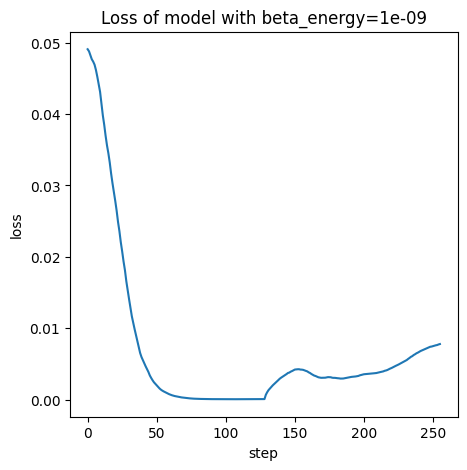

In [90]:
# Run the model
x_steps = []
fireRates_steps = []
for k in range(max_steps):
    if k == 0:
        x = x0
    else: 
        x = x[0]
    with torch.no_grad():
        x, fireRates = model(x, steps=1)
    
    # set a channel to 0
    if k == max_steps//2:
        channel = 14
        x[0,:,:,:,channel] = x[0,:,:,:,channel].transpose(1,2)
        channel = 9
        x[0,:,:,:,channel] = x[0,:,:,:,channel].transpose(1,2)
        
    x_steps.append(x[0])
    fireRates_steps.append(fireRates[0])

x_steps = torch.stack(x_steps)
fireRates_steps = torch.stack(fireRates_steps)

debug("x_steps.shape")

# compute the loss (mean accross the batch)
x_steps = x_steps.detach().cpu()
fireRates_steps = fireRates_steps.detach().cpu()
losses = [torch.mean(F.mse_loss(x_steps[k,:,:,:,:4], pad_target)).item() for k in range(max_steps)]

# plot the loss
plt.figure(figsize=(5, 5))
plt.plot(losses)
plt.xlabel('step')
plt.ylabel('loss')
plt.title(f'Loss of model with beta_energy={beta_energy:.0e}')
plt.show()

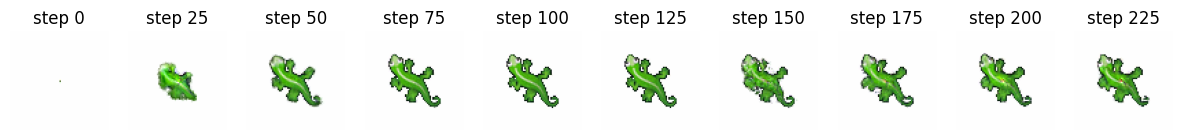

In [91]:
# Plot some steps, in intervals of 25
interval = 25   
plt.subplots(1,max_steps//interval, figsize=(15, 5))
for i in range(max_steps//interval):
    plt.subplot(1,max_steps//interval,i+1)
    plt.imshow(to_rgb(x_steps[i*interval,0]))
    plt.title(f'step {i*interval}')
    plt.axis('off')


In [54]:
debug("x_steps.shape")

x_steps.shape = torch.Size([256, 1, 72, 72, 16])


In [52]:
animate_steps(
    to_rgb(x_steps),
    fireRates_steps,
    x_steps[...,4],
    x_steps[...,5],
    titles = ["CA", "fire rates", "channel 4", "channel 5"],
    colorbar_plots=[1,2,3],
    num_cols=3
)

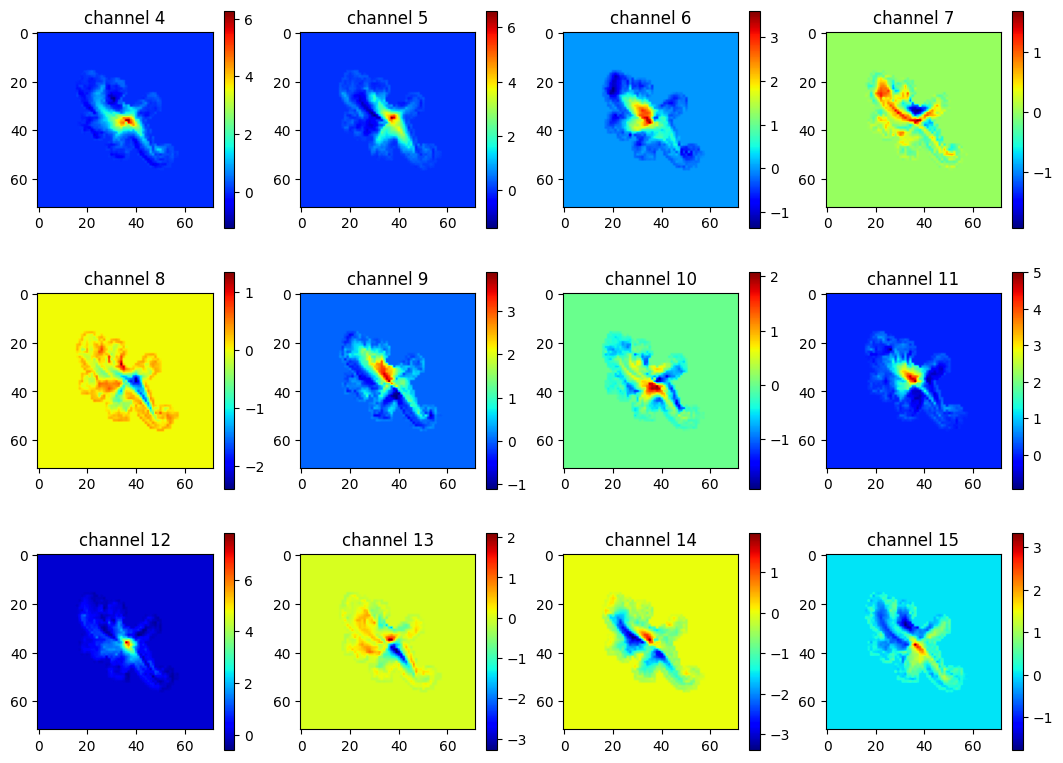

In [58]:
# visualize channels 4-15 at the last step
plt.figure(figsize=(13,13))
for i in range(4, 16):
    plt.subplot(4, 4, i-3)
    plt.imshow(x_steps[-1,0,:,:,i].detach().cpu(), cmap='jet')
    plt.title(f"channel {i}")
    plt.colorbar()

